In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append("../")

In [3]:
import local_config
from MWE2019.corpus import CorpusFactory
from MWE2019.variations import VariationFinder

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [5]:
ptt = CorpusFactory.GetPttCorpus(local_config.CORPUS_DIR + "/PTT")
ctimes = CorpusFactory.GetNewsCorpus(local_config.CORPUS_DIR + "/China_text")
apple = CorpusFactory.GetNewsCorpus(local_config.CORPUS_DIR + "/Apple_text")

In [6]:
# Sample pattern variations
def build_ngram4_dframe():
    ngram4 = pd.read_csv("../resources/ngram_4.csv")
    ngram4["insertion"] = np.nan
    ngram4["substitution"] = np.nan
    ngram4["deletion"] = np.nan
    return ngram4

In [7]:
NGRAM4_DFRAME_PATH = "../data/ngram4_variation.csv"
if os.path.exists(NGRAM4_DFRAME_PATH):
    ngram4 = pd.read_csv(NGRAM4_DFRAME_PATH)
else:
    ngram4 = build_ngram4_dframe()

In [8]:
ngram4.head()

,ngram,freq,insertion,substitution,deletion
0,台北報導,206875,NaN,NaN,NaN
1,資料來源,121438,NaN,NaN,NaN
2,綜合報導,112063,NaN,NaN,NaN
3,中華民國,58360,NaN,NaN,NaN
4,最重要的,35402,NaN,NaN,NaN


## i. prepare sampling buffer

In [9]:

SAMPLE_RATE = 0.001
np.random.seed(21563)
rand_vec = np.random.random(ngram4.shape[0])
samples = []
for rnd, (ridx, row) in tqdm(zip(rand_vec, ngram4.iterrows()), total=len(rand_vec)):
    if rnd < SAMPLE_RATE:
        if not row.isnull().any(): continue
        samples.append((ridx, row.ngram))

In [10]:
len(samples)

343

In [11]:
samples[:10]

[(2, '綜合報導'),
 (2751, '漸行漸遠'),
 (2954, '不願具名'),
 (4727, '緣木求魚'),
 (5997, '入監服刑'),
 (6401, '鄉民代表'),
 (6825, '只剩下一'),
 (7442, '任何事情'),
 (7799, '工作關係'),
 (9138, '我們一直')]

## ii. compute variation in sample buffer

In [12]:
var_sample = VariationFinder(samples)

pre-compiling variation patterns


In [13]:
var_sample.sample_patterns[0]

[('sub', re.compile(r'綜[㐀-\u9fff]報導', re.UNICODE)),
 ('del', re.compile(r'綜報導', re.UNICODE)),
 ('sub', re.compile(r'綜合[㐀-\u9fff]導', re.UNICODE)),
 ('del', re.compile(r'綜合導', re.UNICODE)),
 ('ins', re.compile(r'綜.{,10}?合.{,10}?報.{,10}?導', re.UNICODE))]

In [14]:
# reset the results buffer
var_sample.variation_results = {}

## iterate over apple articles

In [15]:
def sample_articles(art_it, ratio=0.05):
    articles = [x for x in art_it if np.random.random() < ratio] 
    return articles

In [16]:
# apple_it = apple.articles()
# apple_articles = [next(apple_it) for _ in range(100)]
# apple_articles = list(apple.articles())
apple_articles = sample_articles(apple.articles())

In [17]:
dummy_articles = [[0,0,"綜合以上報導"],[0,0,"綜合爆導"],[0,0,"綜報導"]]

In [18]:
print(len(apple_articles), sum(len(x[2]) for x in apple_articles))

37954 33728336


In [19]:
result_buf = var_sample.search_in_corpus(apple_articles, 4)
# var_sample.search_in_corpus(dummy_articles, 4)

In [20]:
it = iter(var_sample.variation_results.items())
for _ in range(10):
    print(next(it))

((2, '綜合報導'), {'ins': 1756, 'del': 0, 'sub': 0})
((2751, '漸行漸遠'), {'ins': 2, 'del': 5, 'sub': 0})
((2954, '不願具名'), {'ins': 14, 'del': 80, 'sub': 5})
((4727, '緣木求魚'), {'ins': 0, 'del': 0, 'sub': 0})
((5997, '入監服刑'), {'ins': 3, 'del': 0, 'sub': 32})
((6401, '鄉民代表'), {'ins': 9, 'del': 9, 'sub': 1})
((6825, '只剩下一'), {'ins': 33, 'del': 81, 'sub': 22})
((7442, '任何事情'), {'ins': 26, 'del': 11, 'sub': 20})
((7799, '工作關係'), {'ins': 147, 'del': 4, 'sub': 1})
((9138, '我們一直'), {'ins': 92, 'del': 386, 'sub': 62})


# update ngram4 dataframe

In [21]:
timestamp = datetime.now().strftime("%y%m%d%H%M%S")
ngram4.to_csv(NGRAM4_DFRAME_PATH.replace(".csv", f"_{timestamp}.csv"))

In [22]:
for sample_x, var_result in tqdm(var_sample.variation_results.items()):    
    sample_id = sample_x[0]    
    sub = var_result["sub"]
    ins = var_result["ins"]
    delt = var_result["del"]    
    ngram4.loc[sample_id, "substitution"] = sub
    ngram4.loc[sample_id, "insertion"] = ins
    ngram4.loc[sample_id, "deletion"] = delt

In [23]:
ngram4["deletion"].dropna().sum()

19046.0

In [24]:
ngram4.to_csv(NGRAM4_DFRAME_PATH)

# Make simple visualizations

In [26]:
import matplotlib.pyplot as plt

array([[1.        , 0.31914085],
       [0.31914085, 1.        ]])

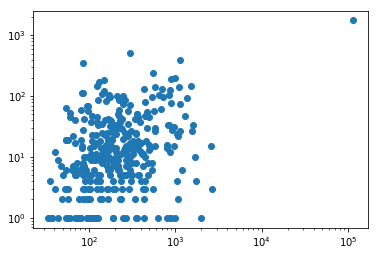

In [51]:
ng = ngram4.dropna()
plt.scatter(ng.freq, ng.insertion+1)
plt.xscale('log')
plt.yscale('log')
np.corrcoef(np.log(ng.freq), np.log(ng.insertion+1))

array([[1.        , 0.15834937],
       [0.15834937, 1.        ]])

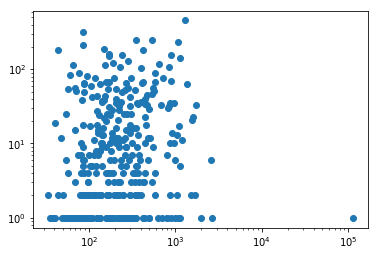

In [52]:
plt.scatter(ng.freq, ng.substitution+1)
plt.xscale('log')
plt.yscale('log')
np.corrcoef(np.log(ng.freq), np.log(ng.substitution+1))

array([[1.        , 0.16679479],
       [0.16679479, 1.        ]])

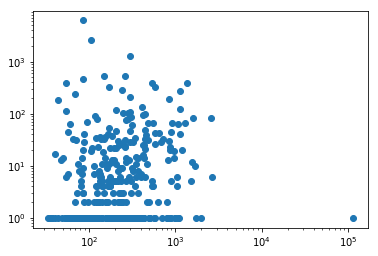

In [53]:
plt.scatter(ng.freq, ng.deletion+1)
plt.xscale('log')
plt.yscale('log')
np.corrcoef(np.log(ng.freq), np.log(ng.deletion+1))

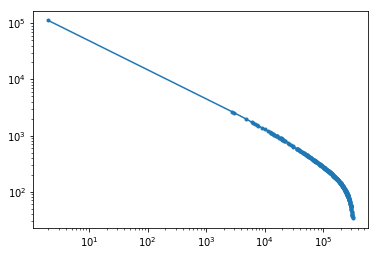

In [49]:
plt.plot(ngram4.loc[~ngram4.insertion.isnull(), "freq"], '.-')
plt.yscale("log")
plt.xscale("log")

In [55]:
ng.to_csv("../data/sampled_ngram4.csv")